In [2]:
import os
from natsort import natsorted
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
from math import trunc
import json

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
import struct
import sys
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle                

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

# Helper functions

In [3]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xlest, yleft, width, height]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    
    if len(gt_boxes)==0:
        tp=0
        fp=len(pred_boxes)
        fn=0
        return [tp, fp, fn]
    
    if len(pred_boxes)==0 & len(gt_boxes) != 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]

    if len(pred_boxes)==0 & len(gt_boxes) == 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]
    
    tp = 0
    
    for i in range(0, len(gt_boxes)):
        for h in range(0, len(pred_boxes)):
            if(calc_iou(gt_boxes[i],pred_boxes[h]) >= iou_thr):
                if(tp < len(pred_boxes)):
                    tp += 1
        fp = len(pred_boxes) - tp
        fn = len(gt_boxes) - tp

    return [tp, fp, fn]

In [4]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    returns the IoU ratio
    '''
    
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox[0] , gt_bbox[1], gt_bbox[0] + gt_bbox[2] , gt_bbox[1] + gt_bbox[3]
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox[0] , pred_bbox[1], pred_bbox[0] + pred_bbox[2] , pred_bbox[1] + pred_bbox[3]
    
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
        
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

# DATASET Preparation

Extract the paths of the images that have been downloaded and save them in a list called "every_path"

For each image append the ground truth boxes in the list "bboxes"

In [5]:
f = open(r'D:\Yolo_Test\DATASET\labels.json')
data = json.load(f)
annotations = data['annotations']
every_path = []
cols = 10
rows = 578
bbox_size = 4
counters = [0] * rows
bboxes = [[] for i in range(rows)] 
items = 0
# Creation of the list of paths of images in the dataset and bboxes
# This elements are extracted from the json file downloaded from coco with the dataset
persons = listdir_fullpath(r'D:\Yolo_Test\DATASET\Person')
for entry in data['annotations']:
    class_id = entry['category_id']
    if (class_id == 1):
        img_id = entry['image_id']
        path = float(img_id)/pow(10,11)
        dec_path = format(path, '.11f')
        dec_path = dec_path.replace('.', '') + ".jpg"
        final_path = "D:\\Yolo_Test\\DATASET\\Person\\" + dec_path
        if(persons.count(final_path) != 0):
            if(every_path.count(final_path) == 0):
                every_path.append(final_path)
                bboxes[items].append(entry['bbox'])
                items = items + 1
            else:
                index = every_path.index(final_path)
                bboxes[index].append(entry['bbox'])
                counters[index] = counters[index] + 1
                    
non_persons = listdir_fullpath(r'D:\Yolo_Test\DATASET\nonPerson')
for i in range(0, len(non_persons)):
    every_path.append(non_persons[i])

print("The notebook is evaluating performances over " + str(len(every_path)) + " images of different sizes")

The notebook is evaluating performances over 578 images of different sizes


# Hog Evaluation

Exploiting the hog detector provided by OpenCV, this detector returns a list of proposed boxes for an image

In [14]:
def hog_detector(im_path, true_bboxes): 
    # Initializing the HOG person
    # detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
    # Reading the Image
    image = cv2.imread(im_path)
    
    # Detecting all the regions in the 
    # Image that have a pedestrians inside it
    (regions, _) = hog.detectMultiScale(image, 
                                      winStride=(4, 4),
                                      padding=(4, 4),
                                      scale=1.05)
    
    # Drawing the regions in the Image
    
    print(regions)
    for (x, y, w, h) in regions:
        cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
    for (x, y, w, h) in true_bboxes:
        cv2.rectangle(image, (int(x), int(y)), 
                    (int(x + w), int(y + h)), 
                    (0, 255, 0), 2)
    
    imRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imRGB)
    plt.show()
    
    
    return regions

Now for each image in our dataset we calculate the regions proposed by Hog and save them in the list prop_regions

Then compute the detection rate based on an IOU_threshold, if the IoU threshold is small then more boxes will be considered as correct predictions.

The number of correct predictions will then be compared with the number of supposed predictions, so the number of persons that are supposed to be in the image

The script calculates the detection rate as person detected / total person based on different iou_thresholds

In [95]:
prop_regions = []
for i in range(0,578):
    prop_regions.append(hog_detector(every_path[i]))

In [96]:
iou_thr = 0
iou_thresholds = []
hog_results = np.zeros((100,3))
HOG_precision = np.zeros((100,))
HOG_recall = np.zeros((100,))
HOG_f1 = np.zeros((100,))
HOG_missrate = np.zeros((100,))
for h in range(0,100):
    iou_thr += 0.01  
    iou_thresholds.append(iou_thr)
    tp = 0
    fp = 0
    fn = 0 
    for i in range(0, 578):
        res = get_single_image_results(bboxes[i],prop_regions[i],iou_thr)
        tp += res[0]
        fp += res[1]
        fn += res[2]
    hog_results[h][0] = tp
    hog_results[h][1] = fp
    hog_results[h][2] = fn
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    HOG_precision[h] = tp / (tp + fp)
    HOG_recall[h] = tp / (tp + fn)
    if(prec + rec != 0):
        HOG_f1[h] = 2 * (prec * rec)/ (prec + rec)
    HOG_missrate[h] = fn / (tp + fn) 

PRECISION


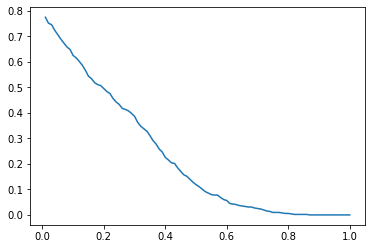

RECALL


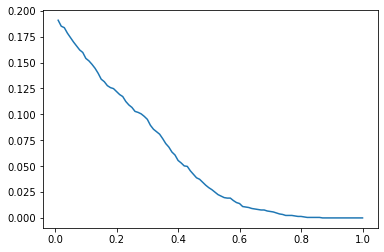

F1 SCORE


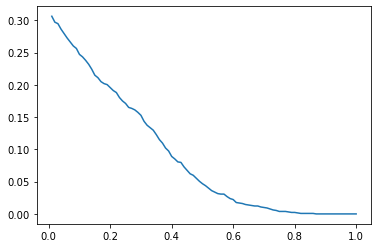

In [97]:
print("PRECISION")
plt.plot(iou_thresholds, HOG_precision)
plt.show()

print("RECALL")
plt.plot(iou_thresholds, HOG_recall)
plt.show()

print("F1 SCORE")
plt.plot(iou_thresholds, HOG_f1)
plt.show()

from scipy.io import savemat

mdic = {"iou_threshold": iou_thresholds}
savemat(r'D:\Stat Evaluation\Results\iou.mat', mdic)

mdic = {"HOG_precision": HOG_precision}
savemat(r'D:\Stat Evaluation\Results\HOG_precision.mat', mdic)

mdic = {"HOG_recall": HOG_recall}
savemat(r'D:\Stat Evaluation\Results\HOG_recall.mat', mdic)

mdic = {"HOG_missrate": HOG_missrate}
savemat(r'D:\Stat Evaluation\Results\HOG_missrate.mat', mdic)

mdic = {"HOG_f1": HOG_f1}
savemat(r'D:\Stat Evaluation\Results\HOG_f1.mat', mdic)

# Viola and Jones evaluation
Now do the same type of evaluation for the Viola and Jones method provided by OpenCV

In [21]:
def viola_detector(im_path, true_bboxes): 
    
    #Reading the Image
    image = cv2.imread(im_path)

    #convert in gray_scale since the cascade classifier works on gray_scale images
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #load the cascade classifier, detect the bodies in the image and draw them for the user to see
    body_cascade = cv2.CascadeClassifier(r'D:\Stat Evaluation\Model\haarcascade_fullbody.xml')
    detected_bodies = body_cascade.detectMultiScale(grayscale_image)
    
    
    for (x, y, w, h) in detected_bodies:
        cv2.rectangle(image, (x, y), (x + w, y + h) ,(0, 0, 255), 4)
    for (x, y, w, h) in true_bboxes:
        cv2.rectangle(image, (int(x), int(y)), 
                    (int(x + w), int(y + h)), 
                    (0, 255, 0), 2)
    
    imRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imRGB)
    plt.show()

    return detected_bodies

In [42]:
prop_regions_viola = []
for i in range(0,578):
    prop_regions_viola.append(viola_detector(every_path[i]))

In [100]:
iou_thr = 0
iou_thresholds = []
viola_results = np.zeros((100,3))
viola_precision = np.zeros((100,))
viola_recall = np.zeros((100,))
viola_f1 = np.zeros((100,))
viola_missrate = np.zeros((100,))
for h in range(0,100):
    iou_thr += 0.01  
    iou_thresholds.append(iou_thr)
    tp = 0
    fp = 0
    fn = 0 
    for i in range(0, 578):
        res = get_single_image_results(bboxes[i],prop_regions_viola[i],iou_thr)
        tp += res[0]
        fp += res[1]
        fn += res[2]
    viola_results[h][0] = tp
    viola_results[h][1] = fp
    viola_results[h][2] = fn
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    viola_precision[h] = tp / (tp + fp)
    viola_recall[h] = tp / (tp + fn)
    if(prec + rec != 0):
        viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
    viola_missrate[h] = fn / (tp + fn) 

PRECISION


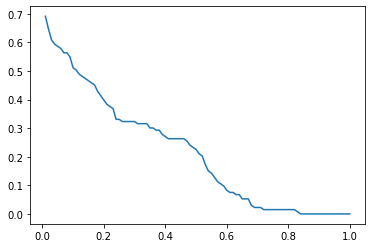

RECALL


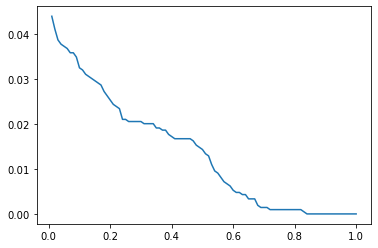

F1 score


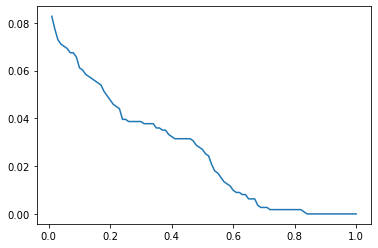

In [101]:
print("PRECISION")
plt.plot(iou_thresholds, viola_precision)
plt.show()

print("RECALL")
plt.plot(iou_thresholds, viola_recall)
plt.show()

print("F1 score")
plt.plot(iou_thresholds, viola_f1)
plt.show()

from scipy.io import savemat

mdic = {"viola_threshold": iou_thresholds}
savemat(r'D:\Stat Evaluation\Results\iou.mat', mdic)

mdic = {"viola_precision": viola_precision}
savemat(r'D:\Stat Evaluation\Results\viola_precision.mat', mdic)

mdic = {"viola_recall": viola_recall}
savemat(r'D:\Stat Evaluation\Results\viola_recall.mat', mdic)

mdic = {"viola_missrate": viola_missrate}
savemat(r'D:\Stat Evaluation\Results\viola_missrate.mat', mdic)

mdic = {"viola_f1": viola_f1}
savemat(r'D:\Stat Evaluation\Results\viola_f1.mat', mdic)

# VIOLA three cascades

The evaluation on the Viola and Jones performs much worse, a reason could be that the cascade classifier is only for full bodies, a way to improve this performance could be to also use the haarcascade upper body and haar cascade lower body and see if it works better

In [24]:
def viola_detector_powered(im_path, true_bboxes): 
    
    #Reading the Image
    image = cv2.imread(im_path)

    #convert in gray_scale since the cascade classifier works on gray_scale images
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #load the cascade classifier, detect the bodies in the image and draw them for the user to see
    body_cascade = cv2.CascadeClassifier(r'D:\Stat Evaluation\Model\haarcascade_fullbody.xml')
    lbody_cascade = cv2.CascadeClassifier(r'D:\Stat Evaluation\Model\haarcascade_lowerbody.xml') #lower body
    ubody_cascade = cv2.CascadeClassifier(r'D:\Stat Evaluation\Model\haarcascade_upperbody.xml') #upper body
  
    detected_bodies = body_cascade.detectMultiScale(grayscale_image)
    ldetected_bodies = lbody_cascade.detectMultiScale(grayscale_image) #lower_body
    udetected_bodies = ubody_cascade.detectMultiScale(grayscale_image) #upper_body
  
    tot_bodies = list(detected_bodies) + list(ldetected_bodies) + list(udetected_bodies) #concatenate all the detected bboxes


    for (x, y, w, h) in tot_bodies:
        cv2.rectangle(image, (x, y), (x + w, y + h) ,(0, 0, 255), 2)
        
    for (x, y, w, h) in true_bboxes:
        cv2.rectangle(image, (int(x), int(y)), 
                    (int(x + w), int(y + h)), 
                    (0, 255, 0), 2)
    
    imRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imRGB)
    plt.show()
    
    return tot_bodies

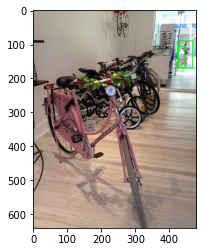

[]

In [27]:
i = 1

viola_detector_powered(every_path[i], bboxes[i])

In [66]:
prop_regions_viola_powered = []
for i in range(0,578):
    prop_regions_viola_powered.append(viola_detector_powered(every_path[i]))

In [98]:
iou_thr = 0
iou_thresholds = []
pow_viola_results = np.zeros((100,3))
pow_viola_precision = np.zeros((100,))
pow_viola_recall = np.zeros((100,))
pow_viola_f1 = np.zeros((100,))
pow_viola_missrate = np.zeros((100,))
for h in range(0,100):
    iou_thr += 0.01  
    iou_thresholds.append(iou_thr)
    tp = 0
    fp = 0
    fn = 0 
    for i in range(0, 578):
        res = get_single_image_results(bboxes[i],prop_regions_viola_powered[i],iou_thr)
        tp += res[0]
        fp += res[1]
        fn += res[2]
    pow_viola_results[h][0] = tp
    pow_viola_results[h][1] = fp
    pow_viola_results[h][2] = fn
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    pow_viola_precision[h] = tp / (tp + fp)
    pow_viola_recall[h] = tp / (tp + fn)
    if(prec + rec != 0):
        pow_viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
    pow_viola_missrate[h] = fn / (tp + fn) 

PRECISION


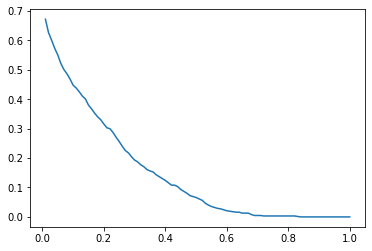

RECALL


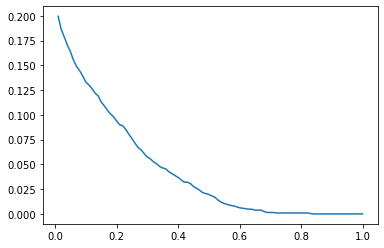

F1 score


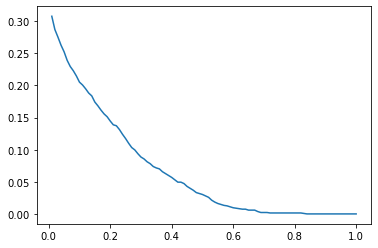

In [99]:
print("PRECISION")
plt.plot(iou_thresholds, pow_viola_precision)
plt.show()

print("RECALL")
plt.plot(iou_thresholds, pow_viola_recall)
plt.show()

print("F1 score")
plt.plot(iou_thresholds, pow_viola_f1)
plt.show()

from scipy.io import savemat

mdic = {"pow_viola_threshold": iou_thresholds}
savemat(r'D:\Stat Evaluation\Results\iou.mat', mdic)

mdic = {"pow_viola_precision": pow_viola_precision}
savemat(r'D:\Stat Evaluation\Results\pow_viola_precision.mat', mdic)

mdic = {"pow_viola_recall": pow_viola_recall}
savemat(r'D:\Stat Evaluation\Results\pow_viola_recall.mat', mdic)

mdic = {"pow_viola_missrate": pow_viola_missrate}
savemat(r'D:\Stat Evaluation\Results\pow_viola_missrate.mat', mdic)

mdic = {"pow_viola_f1": pow_viola_f1}
savemat(r'D:\Stat Evaluation\Results\pow_viola_f1.mat', mdic)

# YOLO v3 evaluation

Do the same type of evaluations on the YOLO v3 model that has been already been trained. The trained model is able to detect 80 classes! However we are only interested in the person class. So we extract only the predicted bounding boxes associated with that class and perform the needed evaluations

The weights are downloaded directly by darknet and mounted on the keras sequential yolo model.

In [57]:
#ALL NECESSARY FUNCTIONS TO DEFINE THE YOLO v3 MODEL in KERAS

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def correct_yolo_boxes2(boxes, image_h, image_w, net_h, net_w):
        
    for i in range(len(boxes)):
        x_scale = image_w/net_w
        y_scale = image_h/net_h
        
        boxes[i].xmin = int(boxes[i].xmin * image_w)
        boxes[i].xmax = int(boxes[i].xmax * image_w)
        boxes[i].ymin = int(boxes[i].ymin * image_h)
        boxes[i].ymax = int(boxes[i].ymax * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0 


# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [29]:
# define the model
model = make_yolov3_model()

# load the model weights
weight_reader = WeightReader(r'D:\Stat Evaluation\Model\yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [30]:
# define the anchors and labels
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
# define the probability threshold for detected objects
class_threshold = 0.6

In [41]:
#Create the scaled (416x416) version of the bboxes
test_bboxes_scaled = []
for i in range(0,len(every_path)):
    bboxes_it = []
    original_img = load_img(every_path[i])
    width, height = original_img.size
    scale_w = 416 / width 
    scale_h = 416 / height
    
    for box in bboxes[i]:
        xleft = int(box[0] * scale_w)
        yleft = int(box[1] * scale_h)
        b_width = int(box[2] * scale_w)
        b_height = int(box[3] * scale_h)
        new_bbox = [xleft,yleft,b_width,b_height]
        bboxes_it.append(new_bbox)
    test_bboxes_scaled.append(bboxes_it)

1/1 [==============================] - 0s 29ms/step


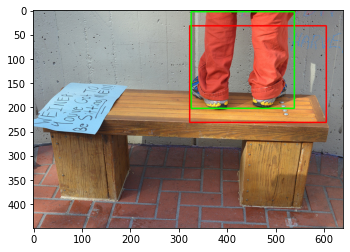

In [73]:
#VISUALIZATION THAT THE MODEL WORKS
i = 120
imCV = cv2.imread(every_path[i])

image = load_img(every_path[i], target_size=(416, 416))

#save the original size of the input image to display it later
image1 = load_img(every_path[i])
width, height = image1.size
# convert to numpy array
image = img_to_array(image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0
image = expand_dims(image, 0)
# make prediction
yhat = model.predict(image)
boxes = list()

for f in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[f][0], anchors[f], 0.6, class_threshold, 416, 416)

correct_yolo_boxes2(boxes, height, width, 416, 416)
# suppress non-maximal boxes
do_nms(boxes, class_threshold)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
detected_persons = []
for h in range(len(v_boxes)):
    if v_labels[h] == "person":
        box = v_boxes[h]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        cv2.rectangle(imCV, (x1,y1), 
                    (x2,y2), 
                    (0, 0, 255), 2)
        
for (x, y, w, h) in bboxes[i]:
    cv2.rectangle(imCV, (int(x), int(y)), 
                    (int(x + w), int(y + h)), 
                    (0, 255, 0), 2)
        
imRGB = cv2.cvtColor(imCV, cv2.COLOR_BGR2RGB)
plt.imshow(imRGB)
plt.show()

    

In [ ]:
prop_regions_yolo = []
for i in range(0,578):
    # load the image with the required size
    image = load_img(every_path[i], target_size=(416, 416))
    image1 = load_img(every_path[i])
    width, height = image.size
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    # make prediction
    yhat = model.predict(image)
    boxes = list()
    for h in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[h][0], anchors[h], 0.6, class_threshold, 416, 416)
    correct_yolo_boxes(boxes, 416, 416, 416, 416)
    # suppress non-maximal boxes
    do_nms(boxes, class_threshold)
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    detected_persons = []
    for f in range(len(v_boxes)):
        if v_labels[f] == "person":
            box = v_boxes[f]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            width_box, height_box = x2 - x1, y2 - y1
            detected_persons.append([x1,y1,width_box,height_box])
    prop_regions_yolo.append(detected_persons) #x,y,w,h

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


In [51]:
iou_thr = 0
iou_thresholds = []
yolo_results = np.zeros((100,3))
yolo_precision = np.zeros((100,))
yolo_recall = np.zeros((100,))
yolo_f1 = np.zeros((100,))
yolo_missrate = np.zeros((100,))
for h in range(0,100):
    iou_thr += 0.01  
    iou_thresholds.append(iou_thr)
    tp = 0
    fp = 0
    fn = 0 
    for i in range(0, 578):
        res = get_single_image_results(test_bboxes_scaled[i],prop_regions_yolo[i],iou_thr)
        tp += res[0]
        fp += res[1]
        fn += res[2]
    yolo_results[h][0] = tp
    yolo_results[h][1] = fp
    yolo_results[h][2] = fn
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    yolo_precision[h] = tp / (tp + fp)
    yolo_recall[h] = tp / (tp + fn)
    if(prec + rec != 0):
        yolo_f1[h] = 2 * (prec * rec)/ (prec + rec)
    yolo_missrate[h] = fn / (tp + fn) 

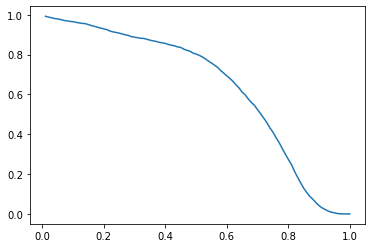

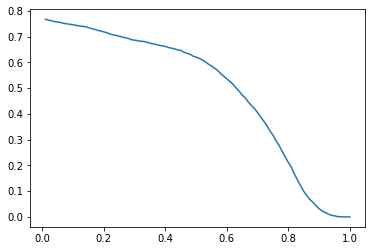

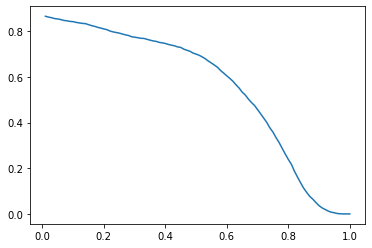

In [52]:
plt.plot(iou_thresholds, yolo_precision)
plt.show()

plt.plot(iou_thresholds, yolo_recall)
plt.show()

plt.plot(iou_thresholds, yolo_f1)
plt.show()

from scipy.io import savemat

mdic = {"yolo_threshold": iou_thresholds}
savemat(r'D:\Stat Evaluation\Results\iou_thresholds.mat', mdic)

mdic = {"yolo_precision": yolo_precision}
savemat(r'D:\Stat Evaluation\Results\yolo_precision.mat', mdic)

mdic = {"yolo_recall": yolo_recall}
savemat(r'D:\Stat Evaluation\Results\yolo_recall.mat', mdic)

mdic = {"yolo_f1": yolo_f1}
savemat(r'D:\Stat Evaluation\Results\yolo_f1.mat', mdic)